In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
os.environ["WANDB_API_KEY"] = "0" ## to silence warning

/kaggle/input/contradictory-my-dear-watson/sample_submission.csv
/kaggle/input/contradictory-my-dear-watson/train.csv
/kaggle/input/contradictory-my-dear-watson/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy() # for CPU and single GPU
print('Number of replicas:', strategy.num_replicas_in_sync)

Number of replicas: 8


In [3]:
train=pd.read_csv('../input/contradictory-my-dear-watson/train.csv')
test=pd.read_csv('../input/contradictory-my-dear-watson/test.csv')
print(train.shape)
print(test.shape)

(12120, 6)
(5195, 5)


In [4]:
train.tail(10)

,id,premise,hypothesis,lang_abv,language,label
12110,ed9d9e8ec2,"Well, we've just got to get down to it, that's...",We should take a break from this.,en,English,2
12111,39ea2c1e23,"-concevoir, dessiner et coudre à la main tous ...",Les costumes n'étaient travaillés que par des ...,fr,French,1
12112,30a3361a15,ہم نہیں جانتے تھے کہ یو 2 (U2) کیا تھا اور کوئ...,ہم نے ہوا میں جو چیز دیکھی ہمیں اس کا نام معلو...,ur,Urdu,1
12113,3fb793c27f,The center had become a hodgepodge of unconnec...,The programs at the center were not connected ...,en,English,0
12114,be162b40cc,ปีที่ผ่านมาเด็กที่ถูกทารุณกรรมและถูกละเลยมากกว...,เด็กที่ถูกทารุณและถูกทอดทิ้งส่วนใหญ่เป็นคนกลุ่...,th,Thai,1
12115,2b78e2a914,The results of even the most well designed epi...,All studies have the same amount of uncertaint...,en,English,2
12116,7e9943d152,But there are two kinds of the pleasure of do...,But there are two kinds of the pleasure of doi...,en,English,0
12117,5085923e6c,The important thing is to realize that it's wa...,"It cannot be moved, now or ever.",en,English,2
12118,fc8e2fd1fe,At the west end is a detailed model of the who...,The model temple complex is at the east end.,en,English,2
12119,44301dfb14,"For himself he chose Atat??rk, or Father of th...",Ataturk was the father of the Turkish nation.,en,English,0


In [5]:
test.tail(10)

,id,premise,hypothesis,lang_abv,language
5185,d349fe8ab4,Tôi không thể nghĩ rằng nó sẽ tạo ra sự khác b...,"Cho dù anh ta có hành động hay không, quyền lự...",vi,Vietnamese
5186,0242fd3023,เขาน่าจะฉีกกระดาษนั่นและใส่มันลงไปในทราย ทรายท...,เขาจะเผากระดาษ,th,Thai
5187,c2e4b293bf,Al Qaeda na ugaidi ilikuwa mojawapo za ajenda ...,Kulikuwa na mambo mengine ya maana kando ya Al...,sw,Swahili
5188,3189b0ae29,see now in a situation like that the boys are ...,Everyone involved was the same age.,en,English
5189,f88b84f4e1,"Очень скоро друг IRT будет звонить вам, чтобы ...",Вы можете пожертвовать деньги по телефону.,ru,Russian
5190,5f90dd59b0,نیند نے وعدہ کیا کہ موٹل نے سوال میں تحقیق کی.,نیمیتھ کو موٹل کی تفتیش کے لئے معاوضہ دیا جارہ...,ur,Urdu
5191,f357a04e86,The rock has a soft texture and can be bough...,The rock is harder than most types of rock.,en,English
5192,1f0ea92118,她目前的存在，并考虑到他与沃佛斯顿争执的本质，那是尴尬的。,她在与Wolverstone的打斗结束后才在场的事实被看作是很尴尬的。,zh,Chinese
5193,0407b48afb,isn't it i can remember i've only been here ei...,I could see downtown Dallas from where I lived...,en,English
5194,16c2f2ab89,"In Hong Kong you can have a plate, or even a w...",It's impossible to have a plate hand-painted t...,en,English


In [6]:
train.premise.values[1],train.hypothesis.values[1]

('These are issues that we wrestle with in practice groups of law firms, she said. ',
 'Practice groups are not permitted to work on these issues.')

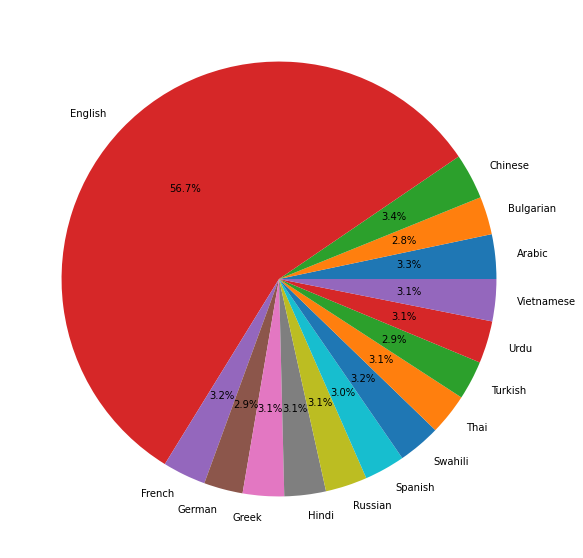

In [7]:
labels, frequencies = np.unique(train.language.values, return_counts = True)

plt.figure(figsize = (10,10))
plt.pie(frequencies,labels = labels, autopct = '%1.1f%%')
plt.show()

In [8]:
train.label.value_counts()

0    4176
2    4064
1    3880
Name: label, dtype: int64

In [9]:
#!pip install transformers
from transformers import TFAutoModel,AutoTokenizer
import tensorflow as tf
#!pip install sentencepiece

In [10]:
tokenizer=AutoTokenizer.from_pretrained('joeddav/xlm-roberta-large-xnli')

train_enc=tokenizer.batch_encode_plus(train[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
test_enc=tokenizer.batch_encode_plus(test[['premise','hypothesis']].values.tolist(),padding='max_length',max_length=100,truncation=True,return_attention_mask=True)
train_tf1=tf.convert_to_tensor(train_enc['input_ids'],dtype=tf.int32)
train_tf2=tf.convert_to_tensor(train_enc['attention_mask'],dtype=tf.int32)
train_input={'input_word_ids':train_tf1,'input_mask':train_tf2}
test_tf1=tf.convert_to_tensor(test_enc['input_ids'],dtype=tf.int32)
test_tf2=tf.convert_to_tensor(test_enc['attention_mask'],dtype=tf.int32)
test_input={'input_word_ids':test_tf1,'input_mask':test_tf2}

Downloading:   0%|          | 0.00/734 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/150 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

In [11]:
train_enc[100]

Encoding(num_tokens=100, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])

In [12]:
with strategy.scope():
    input_ids = tf.keras.Input(shape = (100,), dtype = tf.int32,name='input_word_ids') 
    input_mask=tf.keras.Input(shape=(100,),dtype=tf.int32,name='input_mask')    
    roberta = TFAutoModel.from_pretrained('joeddav/xlm-roberta-large-xnli')
    roberta = roberta([input_ids,input_mask])[0]
    output = tf.keras.layers.GlobalAveragePooling1D()(roberta)
    output = tf.keras.layers.Dense(3, activation = 'softmax')(output)
    model = tf.keras.Model(inputs = [input_ids,input_mask], outputs = output)
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = 1e-5), 
                  loss = 'sparse_categorical_crossentropy', 
                  metrics = ['accuracy']) 
    model.summary()

Downloading:   0%|          | 0.00/2.24G [00:00<?, ?B/s]

Some layers from the model checkpoint at joeddav/xlm-roberta-large-xnli were not used when initializing TFXLMRobertaModel: ['classifier']
- This IS expected if you are initializing TFXLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFXLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFXLMRobertaModel were initialized from the model checkpoint at joeddav/xlm-roberta-large-xnli.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFXLMRobertaModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 100)]        0                                            
__________________________________________________________________________________________________
tfxlm_roberta_model (TFXLMRober TFBaseModelOutputWit 559890432   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 1024)         0           tfxlm_roberta_model[0][0]    

In [13]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True)
model.fit(train_input,train.label,validation_split = 0.2,epochs=20,batch_size=16*strategy.num_replicas_in_sync,callbacks=[early_stop],verbose=1)

Epoch 1/20


/opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:430: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 256002048 elements. This may consume a large amount of memory.
  num_elements)


76/76 [==============================] - 275s 2s/step - loss: 0.4716 - accuracy: 0.8122 - val_loss: 0.2289 - val_accuracy: 0.9237
Epoch 2/20
76/76 [==============================] - 21s 271ms/step - loss: 0.1635 - accuracy: 0.9470 - val_loss: 0.2745 - val_accuracy: 0.9224
Epoch 3/20
76/76 [==============================] - 21s 271ms/step - loss: 0.0839 - accuracy: 0.9738 - val_loss: 0.2925 - val_accuracy: 0.9224


In [14]:
pred=[np.argmax(i) for i in model.predict(test_input)]
pd.DataFrame(pred).value_counts()

0    1812
1    1716
2    1667
dtype: int64

In [15]:
pd.DataFrame({'id':test.id,
              'prediction':pred}).to_csv('submission.csv',index=False)